#<center>A Hybrid Ensemble Learning Approach to Star-galaxy Classification </center>

##<center>Edward Kim, Robert Brunner, and Matias Carrasco Kind</center>

<center>[MNRAS (2015) 453 (1): 507-521](http://mnras.oxfordjournals.org/content/453/1/507)</center>

<center>[arXiv:1505.02200](http://arxiv.org/abs/1505.02200) [astro-ph.IM]</center>

##<center>Abstract</center>

There exist a variety of star-galaxy classification techniques, each with their own strengths and weaknesses. In this paper, we present a novel meta-classification framework that combines and fully exploits different techniques to produce a more robust star-galaxy classification. To demonstrate this hybrid, ensemble approach, we combine a purely morphological classifier, a supervised machine learning method based on random forest, an unsupervised machine learning method based on self-organizing maps, and a hierarchical Bayesian template fitting method. Using data from the CFHTLenS survey, we consider different scenarios: when a high-quality training set is available with spectroscopic labels from DEEP2, SDSS, VIPERS, and VVDS, and when the demographics of sources in a low-quality training set do not match the demographics of objects in the test data set. We demonstrate that our Bayesian combination technique improves the overall performance over any individual classification method in these scenarios. Thus, strategies that combine the predictions of different classifiers may prove to be optimal in currently ongoing and forthcoming photometric surveys, such as the Dark Energy Survey and the Large Synoptic Survey Telescope.

This notebook demonstrates an example of using Bayesian Model Combination (BMC) for the CFHTLenS data.

##<center>I. Introduction</center>

<img src="bmc/images/SGmag.png" width="500">

<center> Image: sample images of stars and galaxies from the SDSS survey at different magnitudes (source: [LCDM website](http://lcdm.astro.illinois.edu/)) </center>

The problem of source classification is fundamental to astronomy and goes as far back as [Messier (1781)](https://en.wikipedia.org/wiki/Charles_Messier). A variety of different strategies have been developed  to tackle this long-standing problem, and yet there is no consensus on the optimal star-galaxy classification strategy. The most commonly used method to classify stars and galaxies in large sky surveys is the morphological separation ([Sebok 1979](http://adsabs.harvard.edu/abs/1979AJ.....84.1526S); [Kron 1980](http://adsabs.harvard.edu/abs/1980ApJS...43..305K); [Valdes 1982](http://adsabs.harvard.edu/abs/1982SPIE..331..465V); [Yee 1991](http://adsabs.harvard.edu/abs/1991PASP..103..396Y); [Vasconcellos et al. 2011](http://adsabs.harvard.edu/abs/2011AJ....141..189V); [Henrion et al. 2011](http://adsabs.harvard.edu/abs/2011MNRAS.412.2286H)). It relies on the assumption that stars appear as point sources while galaxies appear as resolved sources. However, currently ongoing and upcoming large photometric surveys, such as the [Dark Energy Survey (DES)](http://www.darkenergysurvey.org/) and the [Large Synoptic Survey Telescope (LSST)](http://www.lsst.org/lsst/), will detect a vast number of unresolved galaxies at faint magnitudes. Near a survey's limit, the photometric observations cannot reliably separate stars from unresolved galaxies by morphology alone without leading to incompleteness and contamination in the star and galaxy samples.

The contamination of unresolved galaxies can be mitigated by using training based algorithms. Machine learning methods have the advantage that it is easier to include extra information, such as concentration indices, shape information, or different model magnitudes. However, they are only reliable within the limits of the training data, and it can be difficult to extrapolate these algorithms outside the parameter range of the training data. These techniques can be further categorized into supervised and unsupervised learning approaches.

In [supervised learning](https://en.wikipedia.org/wiki/Supervised_learning), the input attributes (e.g. magnitudes or colors) are provided along with the truth labels (e.g. star or galaxy). [Odewahn et al. (1992)](http://adsabs.harvard.edu/abs/1992AJ....103..318O) pioneered the application of neural networks to the star-galaxy classification problem, and it has become a core part of the astronomical image processing software [_SExtractor_](http://www.astromatic.net/software/sextractor). Other successfully implemented examples include decision trees ([Weir, Fayyad, & Djorgovski (1995)](http://adsabs.harvard.edu/abs/1995AJ....109.2401W); [Suchkov, Hanisch, & Margon (2005)](http://adsabs.harvard.edu/abs/2005AJ....130.2439S); [Ball & Brunner (2006)](http://adsabs.harvard.edu/abs/2010IJMPD..19.1049B); [Sevilla-Noarbe & Etayo-Sotos (2015)](http://adsabs.harvard.edu/abs/2015A%26C....11...64S)) and Support Vector Machines ([Fadely, Hogg, & Willman 2012](http://adsabs.harvard.edu/abs/2012ApJ...760...15F)). [Unsupervised machine learning](https://en.wikipedia.org/wiki/Unsupervised_learning) techniques are less common, as they do not utilize the truth labels during the training process, and only the input attributes are used.

<img src="bmc/images/spDR2-000.gif" width="500">
<center>Image: A spectrum of an O star (source: [SDSS](http://classic.sdss.org/dr7/algorithms/spectemplates/))</center>

<img src="bmc/images/spDR2-023.gif" width="500">
<center>Image: A spectrum of a galaxy (source: [SDSS](http://classic.sdss.org/dr7/algorithms/spectemplates/))</center>

Physically based template fitting methods have also been used for the star-galaxy classification problem ([Robin et al. 2007](http://adsabs.harvard.edu/abs/2007ApJS..172..545R); [Fadely, Hogg, & Willman 2012](http://adsabs.harvard.edu/abs/2012ApJ...760...15F)). Template fitting approaches infer a source's properties by finding the best match between the measured set of magnitudes (or colors) and the synthetic set of magnitudes (or colors) computed from a set of spectral templates. Although it is not necessary to obtain a high-quality spectroscopic training sample,
these techniques do require a representative sample of theoretical or empirical templates that span the possible spectral energy distributions (SEDs) of stars and galaxies. Furthermore, they are not exempt from uncertainties due to measurement errors on the filter response curves, or from mismatches between the observed magnitudes and the template SEDs.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function, division, unicode_literals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## II. Data: [CFHTLens](http://cfhtlens.org/astronomers/data-store)

We use photometric data from the [Canada-France-Hawaii Telescope Lensing Survey (CFHTLens)](http://www.cfhtlens.org/). This catalog consists of more than twenty five million objects with a limiting magnitude of $i_{\text{AB}} \approx 25.5$. It covers a total of 154 square degrees in the four fields (named W1, W2, W3, and W4) of [CFHT Legacy Survey (CFHTLS)](http://www.cfht.hawaii.edu/Science/CFHTLS/) observed in the five photometric bands: $u$, $g$, $r$, $i$, and $z$.

We have cross-matched reliable spectroscopic galaxies from the [Deep Extragalactic Evolutionary Probe Phase 2 (DEEP2)](http://deep.ps.uci.edu/), the [Sloan Digital Sky Survey Data Release 10 (SDSS-DR10)](https://www.sdss3.org/dr10/), the [VIsible imaging Multi-Object Spectrograph (VIMOS) Very Large Telescope (VLT) Deep Survey (VVDS)](http://cesam.oamp.fr/vvdsproject/vvds.htm), and the [VIMOS Public Extragalactic Redshift Survey (VIPERS)](http://vipers.inaf.it/). We have selected only sources with very secure redshifts and no bad flags (quality flags -1, 3, and 4 for DEEP2; quality flag 0 for SDSS; quality flags 3, 4, 23, and 24 for VIPERS and VVDS). In the end, we have 8,545 stars and 57,843 galaxies available for the training and testing processes. We randomly select 13,278 objects for the blind testing set, and use the remainder for training and cross-validation. While HB uses only the magnitudes in the five bands, $u$, $g$, $r$, $i$, and $z$, TPC and SOMc are trained with a total of 9 attributes: the five magnitudes and their corresponding colors, $u-g$, $g-r$, $r-i$, and $i-z$. The morphological separation method uses [_SExtractor_](http://www.astromatic.net/software/sextractor)'s  FLUX RADIUS parameter provided by the CFHTLenS catalog.

We use `pandas` to load the CFHTLenS data, using the object IDs as the index column.

In [3]:
df = pd.read_csv('data/cfhtlens_matched.csv', index_col='id')

The CSV files have 100+ columns.

In [4]:
df.head()

,ALPHA_J2000,A_WORLD,BPZ_FILT,BPZ_FLAGFILT,BPZ_NONDETFILT,B_WORLD,BackGr,CHI_SQUARED_BPZ,CLASS_STAR,DELTA_J2000,...,n_exposures_detec,n_exposures_used,pos,scalelength,sp_cat,sp_cat_id,star_flag,true_class,weight,z_spec
id,,,,,,,,,,,,,,,,,,,,,
W3m0m1_11696,214.650267,0.000981,31,0,0,0.000760,0.002792,0.054,0.028628,53.106480,...,7,0,Position ICRS 214.6502668999999 53.10647969000003,0.0000,sdss-dr10,1.493031e+18,0,0,0.0000,0.202653
W3m0m1_13805,215.003288,0.000834,31,0,0,0.000602,0.011452,0.341,0.028643,53.112236,...,7,0,Position ICRS 215.00328799999977 53.1122355599...,0.0000,sdss-dr10,1.491820e+18,0,0,0.0000,0.200794
W3m0m1_14097,214.731917,0.001051,31,0,0,0.000762,0.017118,0.308,0.028655,53.108660,...,7,0,Position ICRS 214.7319170999998 53.10865952999999,0.0000,sdss-dr10,1.493029e+18,0,0,0.0000,0.114782
W3m0m1_14953,214.261103,0.000209,31,0,0,0.000175,-0.003837,0.100,0.028710,53.130319,...,7,0,Position ICRS 214.26110300000002 53.1303185000...,0.0000,sdss-dr10,5.648736e+18,0,0,0.0000,0.773710
W3m0m1_15171,214.211339,0.000205,31,0,0,0.000118,-0.004166,0.136,0.021400,53.132613,...,5,5,Position ICRS 214.21133930000028 53.1326129599...,3.1838,sdss-dr10,5.649857e+18,0,0,15.4507,0.948875


The object IDs of the training set used in the paper are stored in `clens_train_id.txt`. We used these indices to construct the same training set, since we will simply read the save results of TPC, SOMc, and HB from txt files, not run the base classifiers in this notebook.

In [5]:
train_id = pd.read_csv('data/clens_train_id.txt')
train = df.loc[train_id.id]

test_id =pd.read_csv('data/clens_test_id.txt')
test = df.loc[test_id.id]

It's useful to set aside the truth labels.

In [6]:
truth_train = train['true_class'].values
truth_test = test['true_class'].values

## III. Classification Methods

In this section, we present four distinct star-galaxy classification techniques. The first method is a morphological separation method, which uses a hard cut in the half-light radius vs.\ magnitude plane. The second method is a supervised machine learning technique named TPC (Trees for Probabilistic Classification), which uses prediction trees and a random forest ([Carrasco Kind & Brunner 2013](http://adsabs.harvard.edu/abs/2013MNRAS.432.1483C)). The third method is an unsupervised machine learning technique named SOMc, which uses self-organizing maps (SOMs) and a random atlas to provide a classification ([Carrasco Kind & Brunner 2014](http://adsabs.harvard.edu/abs/2014MNRAS.438.3409C)). The fourth method is a Hierarchical Bayesian (HB) template fitting technique based on the work by [Fadely, Hogg, & Willman (2012)](http://adsabs.harvard.edu/abs/2012ApJ...760...15F)), which fits SED templates from star and galaxy libraries to an observed set of measured flux values.

Collectively, these four methods represent the majority of all standard star-galaxy classification approaches published in the literature. It is very likely that any new classification technique would be functionally similar to one of these four methods. Therefore, any of these four methods could in principle be replaced by a similar method. 

### III.1. Morphological classification

The simplest and perhaps the most widely used approach to star-galaxy classification is to make a hard cut in the space of photometric attributes. As a first-order morphological selection of point sources, we adopt a technique that is popular among the weak lensing community. 

In [7]:
r_h_cv = train.FLUX_RADIUS.values
mag_i_cv = train.MAG_i.values

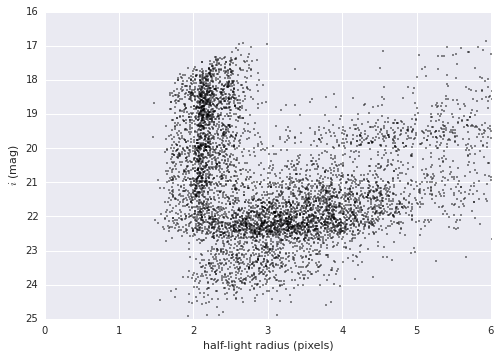

In [8]:
color_true = False
draw_box = False

mag_i_lower = 17
mag_i_upper = 21.0
r_h_lower = 1.4
r_h_upper = 2.8

# select a subset to make the plot not too crowded
rows = np.random.choice(xrange(len(r_h_cv)), size=5000)

if color_true:
    color_star = 'g'
    color_gal = 'b'
else:
        color_star = color_gal = 'k'

mask = truth_train.astype(bool)

plt.scatter(r_h_cv[mask][::3], mag_i_cv[mask][::3], marker='.', s=5, color=color_star)
plt.scatter(r_h_cv[~mask][::10], mag_i_cv[~mask][::10], marker='.', s=5, color=color_gal)

plt.xlabel('half-light radius (pixels)')
plt.ylabel(r'$i$ (mag)')
plt.xlim(0, 6)
plt.ylim(16, 25)
plt.ylim(plt.ylim()[::-1])

if draw_box:
    plt.plot([r_h_upper, r_h_upper], [mag_i_lower, mag_i_upper], c = 'r')
    plt.plot([r_h_lower, r_h_lower], [mag_i_lower, mag_i_upper], c = 'r')
    plt.plot([r_h_lower, r_h_upper], [mag_i_upper, mag_i_upper], c = 'r')
    plt.plot([r_h_upper, r_h_lower], [mag_i_lower, mag_i_lower], c = 'r')

plt.show()

[See code for Figure 1](paper/notebooks/figure01/morph.ipynb)

Figure 1. Half-light radius vs. magnitude.

As figure 1 shows, there is a distinct locus produced by point sources in the half-light radius (estimated by [SExtractor](http://www.astromatic.net/software/sextractor)'s FLUX RADIUS parameter) vs. the $i$-band magnitude plane. A rectangular cut in this size-magnitude plane separates point sources, which are presumed to be stars, from resolved sources, which are presumed to be galaxies. The boundaries of the selection box are determined by manually inspecting the size-magnitude diagram.

One of the disadvantages of such cut-based methods is that it classifies every source with absolute certainty. It is difficult to justify such a decisive classification near a survey's magnitude limits, where measurement uncertainties generally increase. A more informative approach is to provide probabilistic classifications. Although a recent work by [Henrion 2011](http://adsabs.harvard.edu/abs/2011MNRAS.412.2286H) implemented a probabilistic classification using a Bayesian approach on the morphological measurements alone, here we use a cut-based morphological separation to demonstrate the advantages of our combination techniques. In particular, we later show that the binary outputs (i.e., 0 or 1) of cut-based methods can be transformed into probability estimates by combining them with the probability outputs from other probabilistic classification techniques, such as TPC, SOMc, and HB.


A morphological classifier is simple to implement:

In [9]:
def morph_class(magnitude, half_radius, cut=[0, 25, 1.0, 3.0]):
    point_source = ((magnitude > cut[0]) & (magnitude < cut[1]) &
                    (half_radius > cut[2]) & (half_radius < cut[3]))
    return point_source.astype(np.int)

In [10]:
morph_cv = morph_class(mag_i_cv, r_h_cv, cut=[mag_i_lower, mag_i_upper, r_h_lower, r_h_upper])

We use the same morphological classifier to separate stars from galaxies in the test set.

In [11]:
r_h_test = test.FLUX_RADIUS.values
mag_i_test = test.MAG_i.values

morph_test = morph_class(mag_i_test, r_h_test, cut=[mag_i_lower, mag_i_upper, r_h_lower, r_h_upper])

### III.2. Trees for Probabilistic Classification (TPC)

[Carrasco Kind & Brunner (2013)](http://adsabs.harvard.edu/abs/2013MNRAS.432.1483C)

<img src="bmc/images/example_tree.png" width="500">

<center> Image: A visual representation of a random forest (source: [TPZ: Trees for Photo-Z](http://pythonhosted.org/MLZ/tpz.html)) </center>

TPC is a parallel, supervised machine learning algorithm that uses prediction trees and random forest techniques ([Breiman 1984](https://scholar.google.com/citations?view_op=view_citation&hl=en&user=mXSv_1UAAAAJ&citation_for_view=mXSv_1UAAAAJ:u5HHmVD_uO8C)) to produce a star-galaxy classification. TPC is a part of a publicly available software package called [MLZ (Machine Learning for Photo-$z$)](http://lcdm.astro.illinois.edu/static/code/mlz/MLZ-1.2/doc/html/).
The full software package includes: TPZ, a supervised photometric redshift (photo-$z$) estimation technique ([Carrasco Kind & Brunner 2013](http://adsabs.harvard.edu/abs/2013MNRAS.432.1483C)); TPC, a supervised star-galaxy classification technique (classification mode); SOM$z$, an unsupervised photo-$z$ technique ([Carrasco Kind & Brunner 2014](http://adsabs.harvard.edu/abs/2014MNRAS.438.3409C)) ; and SOMc, an unsupervised star-galaxy classification technique (classification mode).

TPC uses classification trees, a type of prediction trees that are designed to provide a classification or predict a discrete category. Prediction trees are built by asking a sequence of questions that recursively split the data into branches until a terminal leaf is created that meets a stopping criterion (e.g., a minimum leaf size). The optimal split dimension is decided by choosing the attribute that maximizes the _Information Gain_ ($I_G$), which is defined as

$$
  I_G \left(D_{\mathrm{node}}, X\right)
  = I_d \left( D_{\mathrm{node}} \right)
  - \sum_{x \in \mathrm{values}(X)}
  \frac{|D_{\mathrm{node}, x}|}{|D_{\mathrm{node}}|}
  I_d \left( D_{\mathrm{node}, x} \right),
$$

where $D_{\mathrm{node}}$ is the training data in a given node, $X$ is one of the possible dimensions (e.g., magnitudes or colors) along which the node is split, and $x$ are the possible values of a specific dimension $X$. $|D_{\mathrm{node}}|$ and $|D_{\mathrm{node}, x}|$ are the size of the total training data and the number of objects in a given subset $x$ within the current node, respectively. $I_d$ is the impurity degree index, and TPC can calculate $I_d$ from any of the three standard different impurity indices: _information entropy_, _Gini impurity_, and _classification error_. In this work, we use the information entropy, which is defined similarly to the thermodynamic entropy:

$$  I_d \left( D \right)
  = - f_g \log_{2} f_g - \left(1 - f_g\right) \log_{2} \left(1 - f_g\right),
$$

where $f_g$ is the fraction of galaxies in the training data. At each node in our tree, we scan all dimensions to identify the split point that maximizes the information gain, and select the attribute that maximizes the impurity index overall.

In a technique called random forest, we create bootstrap samples (i.e., $N$ randomly selected objects with replacement) from the input training data by sampling repeatedly from the magnitudes and colors using their measurement errors. We use these bootstrap samples to construct multiple, uncorrelated prediction trees whose individual predictions are aggregated to produce a star-galaxy classification for each source.

We also use a cross-validation technique called Out-of-Bag (OOB; [Breiman 1984](https://scholar.google.com/citations?view_op=view_citation&hl=en&user=mXSv_1UAAAAJ&citation_for_view=mXSv_1UAAAAJ:u5HHmVD_uO8C), [Carrasco Kind & Brunner (2013)](http://adsabs.harvard.edu/abs/2013MNRAS.432.1483C)). When a tree (or a map) is built in TPC (or SOMc), a fraction of the training data, usually one-third, is left out and not used in training the trees (or maps). After a tree is constructed using two-thirds of the training data, the final tree is applied to the remaining one-third to make a classification. This process is repeated for every tree, and the predictions from each tree are aggregated for each object to make the final star-galaxy classification. We emphasize that if an object is used for training a given tree, it is never used for subsequent prediction by that tree. Thus, the OOB data is an unbiased estimation of the errors and can be used as cross-validation data as long as the OOB data remain similar to the final test data set. The OOB technique can also provide extra information such as a ranking of the relative importance of the input attributes used in the prediction. The OOB technique can prove extremely valuable when calibrating the algorithm, when deciding which attributes to incorporate in the construction of the trees, and when combining this approach with other techniques.

We used XSEDE computing resources to run TPC on [TACC Stampede](https://www.tacc.utexas.edu/) with the following parameters (unimportant parameters are omiitted):

- Att              : u, g, r, i, z, u-g, g-r, r-i, i-z
- PredictionMode   : TPZ_C
- PredictionClass  : Class
- MinZ             : 0
- MaxZ             : 1
- NzBins           : 2
- NRandom          : 5
- NTrees           : 100
- Natt             : 3
- OobError         : yes
- MinLeaf          : 5
- ImpurityIndex    : entropy

Here, we simply load the results, Out-of-Bag (OOB) and test prediction files.

In [12]:
tpc_cv = np.loadtxt('paper/data/clens_tpc_oob.mlz', unpack=True, usecols=(2,))
tpc_test = np.loadtxt('paper/data/clens_tpc_test.mlz', unpack=True, usecols=(2,))

### III.3. Self-Organizing Maps Classification (SOMc)

[Carrasco-Kind & Brunner (2014)](http://adsabs.harvard.edu/abs/2014MNRAS.438.3409C)

<img src="bmc/images/scheme2.png" width="500">

<center> Image: A schematic representation of a SOM (source: [SOMz: Self Organizing Maps and random atlas](http://pythonhosted.org/MLZ/somz.html)) </center>

A [self-organizing map](https://en.wikipedia.org/wiki/Self-organizing_map) ([Kohonen 1998](http://www.sciencedirect.com/science/article/pii/S0925231298000307)) is an unsupervised, artificial neural network algorithm that is capable of projecting high-dimensional input data onto a low-dimensional map through a process of competitive learning. In astronomical applications, the high-dimensional input data can be magnitudes, colors, or some other photometric attributes. The output map is usually chosen to be two-dimensional so that the resulting map can be used for visualizing various properties of the input data. The differences between a SOM and typical neural network algorithms are that a SOM is unsupervised, there are no hidden layers and therefore no extra parameters, and it produces a direct mapping between the training set and the output network. In fact, a SOM can be viewed as a non-linear generalization of a principal component analysis (PCA) algorithm ([Yin 2008](http://link.springer.com/chapter/10.1007%2F978-3-540-78293-3_17)).

The key characteristic of SOM is that
it retains the topology of the input training set,
revealing correlations between input data that are not obvious.
The method is unsupervised:
the user is not required to specify the desired output
during the creation of the lower-dimensional map,
and the mapping of the components from the input vectors
is a natural outcome of the competitive learning process.

During the construction of a SOM,
each node on the two-dimensional map is represented by
weight vectors of the same dimension
as the number of attributes used to create the map itself.
In an iterative process,
each object in the input sample is individually used
to correct these weight vectors.
This correction is determined so that the specific neuron (or node),
which at a given moment best represents the input source,
is modified along with the weight vectors
of that node's neighboring neurons.
As a result, this sector within the map
becomes a better representation of the current input object.
This process is repeated for every object in the training data,
and the entire process is repeated for several iterations.
Eventually, the SOM converges to its final form where
the training data is separated into groups of similar features.
Although the spectroscopic labels are not used at all
in the learning process, they are used
(only after the map has been constructed)
to generate predictions for each cell in the resulting two-dimensional map.

In a similar approach to random forest in TPZ and TPC,
SOM$z$ uses a technique called \textit{random atlas}
to provide photo-$z$ estimation \citep{carrascokind2014somz}.
In random atlas, the prediction trees of random forest are replaced by maps,
and each map is constructed from different bootstrap samples
of the training data.
Furthermore, we create random realizations of the training data
by perturbing the magnitudes and colors by their measurement errors.
For each map, we can either use all available attributes,
or randomly select a subsample of the attribute space.
This SOM implementation can also be
applied to the classification problem,
and we refer to it as SOMc
in order to differentiate it from 
the photo-$z$ estimation problem (regression mode).
We also use the random atlas approach
in some of the classification combination approaches as discussed in
Section IV.

One of the most important parameter in SOMc
is the topology of the two-dimensional SOM,
which can be rectangular, hexagonal, or spherical.
In our SOM implementation, it is also possible
to use periodic boundary conditions for the non-spherical cases.
The spherical topology is by definition periodic and
is constructed by using [HEALPIX](http://healpix.jpl.nasa.gov/).
Similar to TPC,
we use the OOB technique to make an unbiased estimation of errors.
We determine the optimal parameters by performing
a grid search in the parameter space of different toplogies,
as well as other SOM parameters, for the OOB data.
We find that the spherical topology gives the best performance
for the CFHTLenS data, likely due to its natural periodicity.
Thus, we use a spherical topology to classify stars and galaxies
in the CFHTLenS data.
For a complete description of the SOM implementation
and its application to the estimation of
photo-$z$ probability density functions (photo-$z$ PDFs),
we refer the reader to [Carrasco Kind & Brunner (2014)](http://adsabs.harvard.edu/abs/2014MNRAS.438.3409C).

We used XSEDE computing resources to run SOMc on TACC Stampede with the following parameters (unimportant parameters are omiitted):

- Att              : u, g, r, i, z, u-g, g-r, r-i, i-z
- PredictionMode   : SOM
- PredictionClass  : Class
- MinZ             : 0
- MaxZ             : 1
- NzBins           : 2
- NRandom          : 10
- NTrees           : 100
- Natt             : 6
- OobError         : yes
- Topology         : sphere
- Periodic         : yes
- Ntop             : 8
- Iterations       : 200
- SomType          : online
- AlphaStart       : 0.9
- AlphaEnd         : 0.5

Here, we load the resulting Out-of-Bag (OOB) and test prediction files.

In [13]:
som_cv = np.loadtxt('paper/data/clens_som_oob.mlz', unpack=True, usecols=(2,))
som_test = np.loadtxt('paper/data/clens_som_test.mlz', unpack=True, usecols=(2,))

### III.4. Template Fitting: Heirarchical Bayesian

[Fadely, Hoog, & Willman (2015)](http://adsabs.harvard.edu/abs/2012ApJ...760...15F)

![](bmc/images/sdss_cfhtls_ugriz.gif)

<center> Image: The CFHTLS and SDSS filter sets (source: [CFHTLS](http://www1.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/community/CFHTLS-SG/docs/extra/filters.html)) </center>

One of the most common methods to classify a source based on its observed magnitudes is template fitting. Template fitting algorithms do not require a spectroscopic training sample; there is no need for additional knowledge outside the observed data and the template SEDs. However, any incompleteness in our knowledge of the template SEDs that fully span the possible SEDs of observed sources may lead to misclassification of sources.

Bayesian algorithms use Bayesian inference to quantify the relative probability that each template matches the input photometry and determine a probability estimate by computing the posterior that a source is a star or a galaxy. In this work, we have modified and parallelized a publicly available Hierarchical Bayesian (HB) template fitting algorithm by [Fadely, Hogg, & Willman (2012)](http://adsabs.harvard.edu/abs/2012ApJ...760...15F). In this section, we provide a brief description of the HB template fitting technique; for the details of the underlying HB approach, we refer the reader to [Fadely et al. (2012)](http://adsabs.harvard.edu/abs/2012ApJ...760...15F).

We write the posterior probability that a source is a star as

$$ P \left( S | \mathbf{x}, \mathbf{\theta} \right) = P \left( \mathbf{x} | S, \mathbf{\theta} \right) P \left( S | \mathbf{\theta} \right), $$

where $\mathbf{x}$ represents a given set of observed magnitudes. We have also introduced the _hyperparameter_ $\mathbf{\theta}$, a nuisance parameter that characterizes our uncertainty in the prior distribution. To compute the likelihood that a source is a star, we marginalize over all star and galaxy templates $\mathbf{T}$. In a template-fitting approach, we marginalize by summing up the likelihood that a source has the set of magnitudes $\mathbf{x}$ for a given star template as well as the likelihood for a given galaxy template:

$$ P \left(\mathbf{x} | S, \mathbf{\theta} \right) = \sum_{t \in \mathbf{T}} P \left(\mathbf{x} | S, t, \mathbf{\theta} \right) P \left(t | S, \mathbf{\theta} \right).$$

The likelihood of each template $ P \left( \mathbf{x} | S, \mathbf{\theta} \right) $ is itself marginalized over the uncertainty in the template-fitting coefficient. Furthermore, for galaxy templates, we introduce another step that 
marginalizes the likelihood by redshifting a given galaxy template by a factor of $1 + z$.

Marginalization requires that we specify the prior probability $ P \left(t | S, \mathbf{\theta} \right) $ that a source has a spectral template $t$ (at a given redshift). Thus, the probability that a source is a star (or a galaxy) is either the posterior probability itself if a prior is used, or the likelihood itself if an uninformative prior is used. In a Bayesian analysis, it is preferable to use a prior, which can be directly computed either from physical assumptions, or from an empirical function calibrated by using a spectroscopic training sample. In an HB approach, the entire sample of sources is used to infer the prior probabilities for each individual source.

Since the templates are discrete in both SED shape and physical properties, we parametrize the prior probability of each template as a discrete set of weights such that

$$ \sum_{t \in \mathbf{T}} P \left(t | S, \mathbf{\theta} \right) = 1. $$

Similarly, we also parametrize the overall prior probability, $\left(S | \mathbf{\theta}\right)$, as a weight. These weights correspond to the hyperparameters, which can be inferred by sampling the posterior probability distribution in the hyperparameter space. For the sampling, we use [emcee](http://dan.iel.fm/emcee/), a Python implementation of the
affine-invariant Markov Chain Monte Carlo (MCMC) ensemble sampler ([Foreman-Mackey et al. 2013](http://arxiv.org/abs/1202.3665)).  

As the goal of template fitting methods is to minimize the difference between observed and theoretical magnitudes, this approach heavily relies on both the use of SED templates and the accuracy of the transmission functions for the filters used for particular survey. For our stellar templates, we use the empirical SED library from [Pickles (1998)](http://adsabs.harvard.edu/abs/1998PASP..110..863P). The Pickles library consists of 131 stellar templates, which span all normal spectral types and luminosity classes at solar abundance, as well as metal-poor and metal-rich F-K dwarf and G-K giant and supergiant stars. We supplement the stellar library with 100 SEDs from [Chabrier et al. 2000](http://adsabs.harvard.edu/abs/2000ApJ...542..464C), which include low mass stars and brown dwarfs with different $T_{\mathrm{eff}}$ and surface gravities. We also include four white dwarf templates of
[Bohlin, Colina, & Finley (1995)](http://adsabs.harvard.edu/abs/1995AJ....110.1316B), for a total of 235 templates in our final stellar library. For our galaxy templates, we use four CWW spectra from [Coleman, Wu, & Weeman (1980)](http://adsabs.harvard.edu/abs/1980ApJS...43..393C), which include an Elliptical, an Sba, an Sbb, and an Irregular galaxy template. When extending an analysis to higher redshifts, the CWW library is often augmented with two star bursting galaxy templates from [Kinney et al. (1996)](http://adsabs.harvard.edu/abs/1996ApJ...467...38K). From the six original CWW and Kinney spectra, intermediate templates are created by interpolation, for a total of 51 SEDs in our final galaxy library.

All of the above templates are convolved with the filter response curves to generate model magnitudes. These response curves consist of $u$, $g$, $r$, $i$, $z$ filter transmission functions for the observations taken by the Canada-France Hawaii Telescope (CFHT).

In [14]:
hbc_all = np.loadtxt('paper/data/clens_all.hbc', unpack=True, usecols=(0,))
hbc_cv = hbc_all[:len(train)]
hbc_test = hbc_all[len(train):]

## IV. Classification combination methods

Building on the work in the field of ensemble learning, we combine the predictions from individual star-galaxy classification techniques using four combination techniques. The main idea behind ensemble learning is to weight the predictions from individual models and combine them to obtain a prediction that outperforms every one of  them individually ([Rokach 2010](http://link.springer.com/article/10.1007%2Fs10462-009-9124-7)).

### IV.1. Unsupervised Binning

Given the variety of star-galaxy classification methods
we are using,
we fully expect the relative performance
of the individual techniques to vary across
the parameter space spanned by the data.
For example, it is reasonable to expect 
supervised techniques to outperform other techniques
in areas of parameter space that are well-populated
with training data.
Similarly, we can expect unsupervised approaches
such as SOM or template fitting approaches 
to generally perform better when a training sample
is either sparse or unavailable.

We therefore adopt a binning strategy similar to [Carrasco Kind & Brunner (2014)](http://adsabs.harvard.edu/abs/2014MNRAS.442.3380C).
In this binning strategy,
we allow different classifier combinations 
in different parts of parameter space
by creating two-dimensional SOM representations of
the full nine-dimensional magnitude-color space:
$u$, $g$, $r$, $i$, $z$, $u-g$, $g-r$, $r-i$, and $i-z$.
A SOM representation can be rectangular, hexagonal, or spherical;
here we choose a 10$\times$10 rectangular topology to facilitate 
visualization as shown in Figure 2.
We note that this choice is mainly for convenience
and that the optimal topology and map size would likely depend on
a number of factors, such as the number of objects and attributes.
For all combination methods,
we use only the OOB (cross-validation) data contained in each cell
to compute the relative weights for the base classifiers.
The weights within individual cells are then applied to
the blind test data set to make the prediction.

Furthermore, we construct a collection of SOM representations
and subsequently combine the predictions from each map
into a meta-prediction.
Given a training sample of $N$ sources,
we generate $N_R$ random realizations of training data
by perturbing the attributes
with the measured uncertainty for each attribute.
The uncertainties are assumed to be normally distributed.
In this manner,
we reduce the bias towards the data
and introduce randomness in a systematic manner.
For each random realization of a training sample,
we create $N_M$ bootstrap samples of size $N$
to generate $N_M$ different maps.

After all maps are built,
we have a total of $N_R \times N_M$ probabilistic outputs
for each of the $N$ sources.
To produce a single probability estimate for each source,
we could take the mean, the median, or some other simple statistic.
With a sufficient number of maps,
we find that there is usually negligible difference
between taking the mean and taking the median, and
use the median in the following sections.
We note that it is also possible to establish confidence intervals
using the distribution of the probability estimates.

### IV.2. Weighted Average

The simplest approach to combine different combination techniques is
to simply add the individual classifications from the base classifiers
and renormalize the sum.
In this case, the final probability is given by

$$
P\left(S | \mathbf{x}, \mathbf{M} \right)
= \sum_{i} P \left( S | \mathbf{x}, M_{i} \right),
$$

where $\mathbf{M}$ is the set of models
(TPC, SOMc, HB, and morphological separation
in our work).
We improve on this simple approach
by using the binning strategy to
calculate the weighted average of objects in each SOM cell
separately for each map,
and then combine the predictions from each map into a final prediction.


### IV.3. Bucket of Models (BoM)

After the multi-dimensional input data have been binned,
we can use the cross-validation data
to choose the best model within each bin,
and use only that model within that specific bin
to make predictions for the test data.
We use the mean squared error
(MSE; also known as [Brier score](https://en.wikipedia.org/wiki/Brier_score)
as a classification error metric. We define MSE as

$$
\mathrm{MSE} = \frac{1}{N} \sum^{N - 1}_{i = 0}
  \left( y_i - \hat{y}_i \right)^2,
$$

where $\hat{y}_i$ is the actual truth value
(\eg 0 or 1) of the $i^{\text{th}}$ data, 
and $y_{i}$ is the probability prediction made by the models.
Thus, a model with the minimum MSE is chosen in each bin,
and is assigned a weight of one,
and zero for all other models.
However, the chosen model is allowed to vary between different bins.

### IV.4. Stacking

Instead of selecting a single model that performs best within each bin,
we can train a learning algorithm to combine the output values of
several other base classifiers in each bin.
An ensemble learning method of using a meta-classifier
to combine lower-level classifiers is known as _stacking_
or _stacked generalization_ ([Wolpert 1992](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.56.1533)).
Although any arbitrary algorithm
can theoretically be used as a meta-classifier,
a logistic regression or a linear regression is often used
in practice.
In our work,
we use a single-layer multi-response linear regression algorithm,
which often shows the best performance ([Breiman 1996](http://link.springer.com/article/10.1007%2FBF00117832), [Ting 1999](http://arxiv.org/abs/1105.5466)). 
This algorithm
is a variant of the least-square regression algorithm,
where a linear regression model is constructed for each class.

### IV.5. Bayesian Model Combination

Hybrid BMC: [Kim, Brunner & Carrasco-Kind (2015)](http://adsabs.harvard.edu/abs/2015MNRAS.453..507K)

BMC: [Monteith et al. (2011)](http://ieeexplore.ieee.org/xpls/abs_all.jsp?arnumber=6033566&tag=1)

We also use a model combination technique known as Bayesian Model Combination (BMC; [Monteith et al. 2011](http://ieeexplore.ieee.org/xpls/abs_all.jsp?arnumber=6033566&tag=1)), which uses Bayesian principles to generate an ensemble combination of different classifiers. The posterior probability that a source is a star is given by

$$ P \left(S | \mathbf{x}, \mathbf{D}, \mathbf{M}, \mathbf{E} \right) = \sum_{e \in \mathbf{E}} P \left(S | \mathbf{x}, \mathbf{M}, e \right) P \left(e | \mathbf{D} \right), $$

where $\mathbf{D}$ is the data set, and $e$ is an element in the ensemble space $\mathbf{E}$ of possible model combinations. By Bayes' Theorem, the posterior probability of $e$ given $\mathbf{D}$ is given by

$$  P \left(e | \mathbf{D} \right) = \frac{P \left(e \right)}{P \left(\mathbf{D} \right)} \prod_{d \in \mathbf{D}} P \left( d | e \right) \propto P \left(e\right) \prod_{d \in \mathbf{D}} P \left(d | e \right). $$

Here, $P\left(e \right)$ is the prior probability of $e$, which we assume to be uniform. The product of $P\left(d | e\right)$ is over all individual data $d$ in the training data $\mathbf{D}$, and $P\left(\mathbf{D}\right)$ is merely a normalization factor and not important.

For binary classifiers whose output is either zero or one (e.g., a cut-based morphological separation), we assume that each example is corrupted with an average error rate $\epsilon$. This means that $P\left(d|e\right) = 1-\epsilon$ if the combination $e$ correctly predicts class $\hat{y}_i$ for the $i^{\text{th}}$ object, and $P\left(d|e\right) = \epsilon$ if it predicts an incorrect class. The average rate $\epsilon$ can be estimated by the fraction $\left(M_g + M_s\right) / N$,
where $M_g$ is the number of true galaxies classified as stars, $M_s$ is the number of true stars classified as galaxies, and $N$ is the total number of sources. We then have

$$  P \left( e | \mathbf{D} \right) \propto  P \left( e \right) \left(1 - \epsilon \right)^{N - M_s - M_g} \left( \epsilon \right)^{M_s + M_g}. $$

For probabilistic classifiers, we can directly use the probabilistic predictions and write

$$  P \left( e | \mathbf{D} \right) \propto P \left( e \right) \prod_{i=0}^{N-1} \hat{y}_i y_i + \left(1 - \hat{y}_i\right) \left(1 - y_i\right). $$

Although the space $\mathbf{E}$ of potential model combinations is in principle infinite, we can produce a reasonable finite set of potential model combinations by using sampling techniques. In our implementation, the weights of each combination of the base classifiers is obtained by sampling from a Dirichlet distribution. We first set all alpha values of a Dirichlet distribution to unity. We then sample this distribution $q$ times to obtain $q$ sets of weights. For each combination, we assume a uniform prior and calculate $P\left(e|\mathbf{D}\right)$ using the above equations. We select the combination with the highest $P\left(e|\mathbf{D}\right)$, and update the alpha values by adding the weights of the most probable combination to the current alpha values. The next $q$ sets of weights are drawn using the updated alpha values.

We continue the sampling process until we reach a predefined number of combinations, and finally compute the posterior probability that a source is a star (or a galaxy). In this paper, we use a $q$ value of three, and 1,000 model combinations are considered. We also use a binned version of the BMC technique, where we use a SOM representation to apply different model combinations for different regions of the parameter space.

In [15]:
from bmc import bmc

We need the magnitude, magnitude errors, and colors for BMC.

In [16]:
mags = ['MAG_u', 'MAG_g', 'MAG_r', 'MAG_i', 'MAG_z']
magerrs = ['MAGERR_u', 'MAGERR_g', 'MAGERR_r', 'MAGERR_i', 'MAGERR_z']
colors = ['u-g', 'g-r', 'r-i', 'i-z']

We calculate colors and impute bad/missing values (-99, 99) with the mean values of each field.

In [17]:
def impute_mags(df, mags=None, magerrs=None):
    bad_values = [-99, 99]
    df[mags + magerrs] = df[mags + magerrs].replace(bad_values, [np.nan] * len(bad_values))
    return df.fillna(df[mags + magerrs].mean())

def perturb_mags(df, mags=None, magerrs=None):
    for m, merr in zip(mags, magerrs):
        # set replace merr = 0 with a very small value. necessary to avoid numpy scale == 0 error.
        df[merr].where(df[merr] > 0, 1.0e-100, inplace=True)
        df[m] = np.random.normal(df[m].values, df[merr].values)
    return df

def calc_colors(df, colors=None):
    for c in colors:
        df[c] = df['MAG_' + c[0]] - df['MAG_' + c[2]]
    for c in colors:
        df[c].where(df[c] < 4, np.nan, inplace = True)
        df[c].where(df[c] > -1, np.nan, inplace = True)
    df[colors] = df[colors].fillna(df[colors].mean())
    return df

train = impute_mags(train, mags=mags, magerrs=magerrs)
train = calc_colors(train, colors=colors)

test = impute_mags(test, mags=mags, magerrs=magerrs)
test = calc_colors(test, colors=colors)

The class object is unimaginatively named `BMC`.

In [18]:
# warning: this could take a while...
clf = bmc.BMC()

We use only the cross-validation data to calculate the weights. The `fit()` function needs the truth labels for each cross-validation data points (the `truth_train` array). When the "training" is done, it prints out

    Done creating SOM map.

In [19]:
# warning: this could take a while...
base_cv = np.vstack((tpc_cv, som_cv, hbc_cv, morph_cv)).T
clf.fit(train[mags + colors].values, base_cv, truth_train)

Done creating SOM map.


Now we apply the weights to the predictions of each classifier. Note that the truth labels (the `truth_test` array) is not used in the `predict_proba()` function.

In [20]:
base_test = np.vstack((tpc_test, som_test, hbc_test, morph_test)).T
clf_test = clf.predict_proba(test[mags + colors].values, base_test)

## V. Results and Discussion

In this section, we present the classification performance of
the four different combination techniques,
as well as the individual star-galaxy classification techniques
on the CFHTLenS test data.

### V.1. Classification Metrics

Probabilistic classification models can be considered as
functions that output a probability estimate of each source
to be in one of the classes (e.g., a star or a galaxy).
Although the probability estimate can be used as a weight 
in subsequent analyses to improve or enhance
a particular measurement ([Ross 2011](http://adsabs.harvard.edu/abs/2011MNRAS.417.1350R)),
it can also be converted into a class label
by using a threshold (a probability cut).
The simplest way to choose the threshold is to set it to a fixed value,
e.g., $p_\mathrm{cut} = 0.5$.
This is, in fact, what is often done (e.g.,
[Henrion et al. 2011](http://adsabs.harvard.edu/abs/2011MNRAS.412.2286H); [Fadely, Hogg, & Willman 2012](http://adsabs.harvard.edu/abs/2012ApJ...760...15F)).
However, choosing $0.5$ as a threshold is not the best choice
for an unbalanced data set, where galaxies outnumber stars.
Furthermore, setting a fixed threshold ignores the operating condition 
(e.g., science requirements, stellar distribution, misclassification costs)
where the model will be applied.


### V.1.1. Receiver Operating Characteristic Curve

When we have no information about the operating condition
when evaluating the performance of classifiers,
there are effective tools such as
the Receiver Operating Characteristic (ROC) curve ([Swets 2000](http://www.scientificamerican.com/article/better-decisions-through-science/)).
An ROC curve is a graphical plot that illustrates the true positive rate
versus the false positive rate of a binary classifier
as its classification threshold is varied.
The Area Under the Curve (AUC) summarizes the curve information
in a single number,
and can be used as an assessment of the overall performance.

### V.1.2. Completeness and Purity

In astronomical applications,
the operating condition usually translates to
the completeness and purity requirements of the star or galaxy sample.
We define the galaxy _completeness_
$c_g$ (also known as recall or sensitivity) as
the fraction of the number of true galaxies classified as galaxies
out of the total number of true galaxies,

$$
c_g = \frac{N_g}{N_g + M_g},
$$

where $N_g$ is the number of true galaxies classified as galaxies,
and $M_g$ is the number of true galaxies classified as stars.
We define the galaxy _purity_ $p_g$ (also known as precision
or positive predictive value)
as the fraction of the number of true galaxies classified as galaxies
out of the total number of objects classified as galaxies, 

$$
p_g = \frac{N_g}{N_g + M_s},
$$

where $M_s$ is the number of true stars classified as galaxies.
Star completeness and purity are defined in a similar manner.


One of the advantages of a probabilistic classification is
that the threshold can be adjusted to produce
a more complete but less pure sample,
or a less complete but more pure one.
To compare the performance of probabilistic classification techniques
with that of morphological separation,
which has a fixed completeness ($c_g = 0.9964$, $c_s = 0.7145$)
at a certain purity ($p_g = 0.9597$, $p_s = 0.9666$),
we adjust the threshold of probabilistic classifiers
until the galaxy completeness $c_g$ matches
that of morphological separation
to compute the galaxy purity $p_{g}$ at $c_g=0.9964$.
Similarly, the star purity $p_{s}$ at $c_{s}=0.7145$
is computed by adjusting the threshold
until the star completeness of each classifier is equal to
that of morphological separation.


We can also compare the performance of different classification techniques
by assuming an arbitrary operating condition.
For example, weak lensing science measurements
of the DES require $c_g > 0.960$ and $p_g > 0.778$
to control both the statistical and systematic errors
on the cosmological parameters,
and $c_s > 0.250$ and $p_s > 0.970$
for stellar Point Spread Function (PSF) calibration
([Soumagnac et al. 2013](http://adsabs.harvard.edu/abs/2015MNRAS.450..666S)).
Although these values will likely be different
for the science cases of the CFHTLenS data,
we adopt these values to compare the classification performance
at a reasonable operating condition.
Thus, we compute $p_{g}$ at $c_g=0.960$
and $p_{s}$ at $c_s=0.250$.
We also use the MSE as a classification error metric.

### V.2. Classifier Combination

We present in Table 2
the classification performance obtained by
applying the four different combination techniques,
as well as the individual star-galaxy classification techniques,
on the CFHTLenS test data.
The bold entries highlight the best technique for any particular metric.
The first four rows show the performance of four individual star-galaxy
classification techniques.
Given a high-quality training data, it is not surprising that 
our supervised machine learning technique TPC
outperforms other unsupervised techniques.
TPC is thus shown in the first row as the benchmark.

In [21]:
from IPython.display import HTML

HTML('''
<table style="width:100%">
  <tr>
    <td>Classifier</td>
    <td>AUC</td>
    <td>MSE</td>
    <td>$p_g (c_g=0.9964)$</td>
    <td>$p_s (c_s=0.7145)$</td>
    <td>$p_g (c_g=0.9600)$</td>
    <td>$p_s (c_s=0.2500)$</td>
  </tr>
  <tr>
    <td>TPC</td>
    <td><b>0.9870</b></td>
    <td>0.0208</td>
    <td>0.9714</td>
    <td>0.9838</td>
    <td>0.9918</td>
    <td>0.9977</td>
  </tr>
  <tr>
    <td>SOMc</td>
    <td>0.9683</td>
    <td>0.0452</td>
    <td>0.9125</td>
    <td>0.8454</td>
    <td>0.9788</td>
    <td>0.9551</td>
  </tr>
  <tr>
    <td>HB</td>
    <td>0.9403</td>
    <td>0.0705</td>
    <td>0.9219</td>
    <td>0.7017</td>
    <td>0.9471</td>
    <td>0.6963</td>
  </tr>
  <tr>
    <td>Morphology</td>
    <td>-</td>
    <td>0.0397</td>
    <td>0.9597</td>
    <td>0.9666</td>
    <td>-</td>
    <td>-</td>
  </tr>
  <tr>
    <td>WA</td>
    <td>0.9806</td>
    <td>0.0266</td>
    <td>0.9755</td>
    <td>0.9926</td>
    <td>0.9872</td>
    <td>0.9977</td>
  </tr>
  <tr>
    <td>BoM</td>
    <td>0.9870</td>
    <td>0.0208</td>
    <td>0.9714</td>
    <td>0.9838</td>
    <td>0.9918</td>
    <td>0.9977</td>
  </tr>
  <tr>
    <td>Stacking</td>
    <td>0.9842</td>
    <td>0.0194</td>
    <td>0.9752</td>
    <td>0.9902</td>
    <td>0.9918</td>
    <td><b>1.0000</b></td>
  </tr>
  <tr>
    <td>BMC</td>
    <td>0.9852</td>
    <td><b>0.0174</b></td>
    <td><b>0.9800</b></td>
    <td><b>0.9959</b></td>
    <td><b>0.9924</b></td>
    <td><b>1.0000</b></td>
  </tr>
</table>''')

Classifier,AUC,MSE,$p_g (c_g=0.9964)$,$p_s (c_s=0.7145)$,$p_g (c_g=0.9600)$,$p_s (c_s=0.2500)$
TPC,0.9870,0.0208,0.9714,0.9838,0.9918,0.9977
SOMc,0.9683,0.0452,0.9125,0.8454,0.9788,0.9551
HB,0.9403,0.0705,0.9219,0.7017,0.9471,0.6963
Morphology,-,0.0397,0.9597,0.9666,-,-
WA,0.9806,0.0266,0.9755,0.9926,0.9872,0.9977
BoM,0.9870,0.0208,0.9714,0.9838,0.9918,0.9977
Stacking,0.9842,0.0194,0.9752,0.9902,0.9918,1.0000
BMC,0.9852,0.0174,0.9800,0.9959,0.9924,1.0000


[See code](paper/notebooks/table02/metrics_all.ipynb)

Table 2. A summary of the classification performance metrics for the four individual methods and the four different classification combination methods as applied to the CFHTLenS data, with no cut applied to the training data set. The definition of the metrics is summarized in Table 1. The bold entries highlight the best performance values within each column. Note that some objects in the test set have bad or missing values (e.g., $-99$ or $99$) in one or more attributes, which are included here (but are omitted, for example, in Figure 5 when the corrsponding attribute is not available.)

The simplest of the combination techniques, WA and BoM,
generally do not perform better than TPC.
It is also interesting that,
even with binning the parameter space and selecting the best model
within each bin,
BoM almost always chooses TPC as the best model in all bins,
and therefore gives the same performance as TPC in the end.
However, our BMC and stacking techniques have a similar performance
and often outperform TPC.
Although TPC shows the best performance as measured by the AUC,
BMC shows the best performance in all other metrics.

To visualize the SOM projections, let's choose some colors from Seaborn's color pallete.

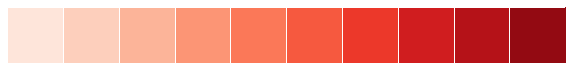

In [22]:
cmap1 = sns.choose_colorbrewer_palette('sequential', as_cmap=True)

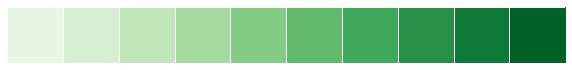

In [23]:
cmap2 = sns.choose_colorbrewer_palette('sequential', as_cmap=True)

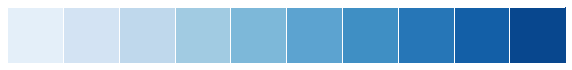

In [24]:
cmap3 = sns.choose_colorbrewer_palette('sequential', as_cmap=True)

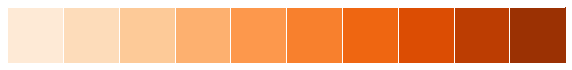

In [25]:
cmap4 = sns.choose_colorbrewer_palette('sequential', as_cmap=True)

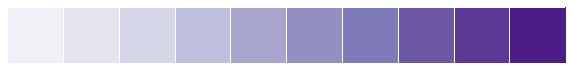

In [26]:
cmap5 = sns.choose_colorbrewer_palette('sequential', as_cmap=True)

The hybrid `BMC` algorithm creates a SOM cell. These cells are stored in the `cells` directory.

In [49]:
from matplotlib import gridspec

n_grid = 10
clens_som_cell = np.load('bmc/cells/cv_cells.0.npy')

# calculate mean values for each cell

def calc_cell_mean(x, som_cells, n_grid):
    x_cells = np.zeros(n_grid**2)
    for i in xrange(n_grid**2):
        i_cell = np.where(som_cells == i)
        x_cells[i] = x[i_cell].mean()
    
    return x_cells.reshape((n_grid, n_grid))

mag_i_cells = calc_cell_mean(train['MAG_i'].values, clens_som_cell, 10)
clr_u_g_cells = calc_cell_mean(train['u-g'].values, clens_som_cell, 10)
clr_g_r_cells = calc_cell_mean(train['g-r'].values, clens_som_cell, 10)
star_frac_cells = calc_cell_mean(truth_train, clens_som_cell, 10)

In Figure 2, we show in the top left panel
the mean CFHTLenS $i$-band magnitude in each cell,
and in the top right panel the fraction of stars in each cell.
The bottom two panels show the mean $u-g$ and  $g-r$ colors in each cell.
These two-dimensional maps clearly show
the ability of the SOM to preserve relationships between sources
when it projects the full nine-dimensional space to the two-dimensional map.
We note that these SOM maps should only be used to provide guidance,
as the SOM mapping is a non-linear representation of all magnitudes and colors.

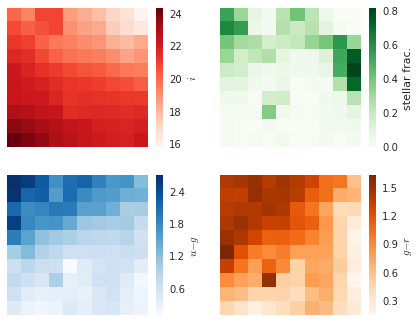

In [50]:
gs = gridspec.GridSpec(2, 3, height_ratios = (1, 1), width_ratios = (9, 9, 1))

ax1 = plt.subplot(gs[0, 0])
im1 = ax1.matshow(mag_i_cells, cmap=cmap1)
ax1.set_xticks([])
ax1.set_yticks([])
cb1 = plt.colorbar(im1)
cb1.set_ticks([16, 18, 20, 22, 24])
cb1.set_label(r'$i$')

ax2 = plt.subplot(gs[0, 1])
im2 = ax2.matshow(star_frac_cells, cmap=cmap2)
ax2.set_xticks([])
ax2.set_yticks([])
cb2 = plt.colorbar(im2)
cb2.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
cb2.set_label('stellar frac.')

ax3 = plt.subplot(gs[1, 0])
im3 = ax3.matshow(clr_u_g_cells, cmap=cmap3)
ax3.set_xticks([])
ax3.set_yticks([])
cb3 = plt.colorbar(im3)
cb3.set_ticks([0, 0.6, 1.2, 1.8, 2.4])
cb3.set_label(r'$u-g$')

ax4 = plt.subplot(gs[1, 1])
im4 = ax4.matshow(clr_g_r_cells, cmap=cmap4)
ax4.set_xticks([])
ax4.set_yticks([])
cb4 = plt.colorbar(im4)
cb4.set_label(r'$g-r$')
cb4.set_ticks([0.3, 0.6, 0.9, 1.2, 1.5])

plt.savefig('bmc/images/som_colors.png')

[See code for Figure 2](paper/notebooks/figure02/som_colors.ipynb)

Figure 2: A two-dimensional 10$\times$10 SOM representation showing the mean $i$-band magnitude (top left), the fraction of true stars in each cell (top right), and the mean values of $u-g$ (bottom left) and $g-r$ (bottom right) for the cross-validation data.


We can also use the same SOM from Figure 2
to determine the relative weights for 
the four individual classification methods in each cell.
We present the four weight maps for the BMC technique in Figure 3.

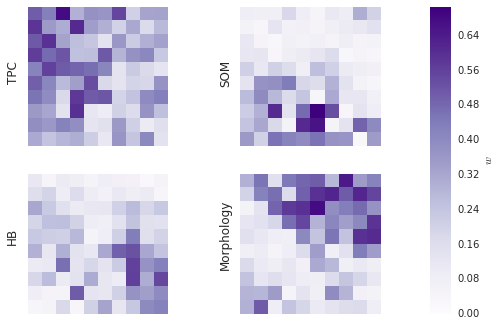

In [51]:
tpc_cells = np.zeros(n_grid**2)
som_cells = np.zeros(n_grid**2)
hbc_cells = np.zeros(n_grid**2)
morph_cells = np.zeros(n_grid**2)

for i in xrange(n_grid**2):
    
    weights = np.load('bmc/weights/bmc_weights.0.' + str(i) + '.npy')

    w = np.sum(weights, axis = 0)
    w = w / w.sum()

    tpc_cells[i] = w[0]
    som_cells[i] = w[1]
    hbc_cells[i] = w[2]
    morph_cells[i] = w[3]

tpc_cells = tpc_cells.reshape((n_grid, n_grid))
som_cells = som_cells.reshape((n_grid, n_grid))
hbc_cells = hbc_cells.reshape((n_grid, n_grid))
morph_cells = morph_cells.reshape((n_grid, n_grid))

gs = gridspec.GridSpec(2, 3, height_ratios = (1, 1), width_ratios = (9, 9, 1))

vmax = np.max([tpc_cells, som_cells, hbc_cells, morph_cells])
rotation = 'vertical'

ax1 = plt.subplot(gs[0, 0])
im1 = ax1.matshow(tpc_cells, vmin=0, vmax=vmax, cmap=cmap5)
ax1.set_title('TPC', rotation = rotation, x = -0.1, y = 0.5)
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = plt.subplot(gs[0, 1])
ax2.matshow(som_cells, vmin=0, vmax=vmax, cmap=cmap5)
ax2.set_title('SOM', rotation = rotation, x = -0.1, y = 0.5)
ax2.set_xticks([])
ax2.set_yticks([])

ax3 = plt.subplot(gs[1, 0])
ax3.matshow(hbc_cells, vmin=0, vmax=vmax, cmap=cmap5)
ax3.set_title('HB', rotation = rotation, x = -0.1, y = 0.5)
ax3.set_xticks([])
ax3.set_yticks([])

ax4 = plt.subplot(gs[1, 1])
ax4.matshow(morph_cells, vmin=0, vmax=vmax, cmap=cmap5)
ax4.set_title('Morphology', rotation = rotation, x = -0.1, y = 0.7)
ax4.set_xticks([])
ax4.set_yticks([])

ax5 = plt.subplot(gs[0:, 2])
cb1 = plt.colorbar(im1, cax=ax5)
cb1.set_label(r'$w$')
cb1.set_clim([0, vmax])

plt.savefig('bmc/images/weights.png')

Figure 3: A two-dimensional 10$\times$10 SOM representation showing the relative weights for the BMC combination technique applied to the four individual methods for the CFHTLenS data.

In these maps, a darker color indicates a higher weight,
or equivalently that the corresponding classifier
performs better in that region.
These weight maps demonstrate the variation in
the performance of the individual techniques across
the two-dimensional parameter space defined by the SOM.
Furthermore, since the maps in Figure 2 and 3
are constructed using the same SOM,
we can determine the region in the parameter space
where each individual technique performs better or worse.
Not surprisingly, the morphological separation
performs best in the top left corner of the weight map
in Figure 3,
which corresponds to the brightest CFHTLenS magnitudes $i \leq 20$
in the $i$-band magnitude map of Figure 2.
It is also clear that the SOM cells where the morphological
separation performs best have higher stellar fraction than
the other cells. 
On the other hand, TPC seems to perform best
in the region that corresponds to intermediate magnitudes
$20\leq i \leq 22.5$ and $1.5 \leq u-g \leq 3.0$.
Our unsupervised learning method SOMc
performs relatively better at fainter magnitudes $i \geq 21.5$
with $0 \leq u-g \leq 0.5$ and $0 \leq g-r \leq 0.5$.
Although HB shows the worst performance
when there exists a high-quality training data set,
BMC still utilizes information from HB,
especially at intermediate magnitudes $20\leq i \leq 22$.
Another interesting pattern is that
the four techniques seem complementary,
and they are weighted most strongly in different regions
of the SOM representation.

,

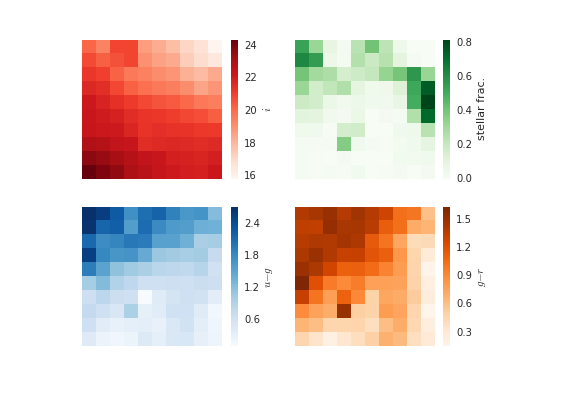
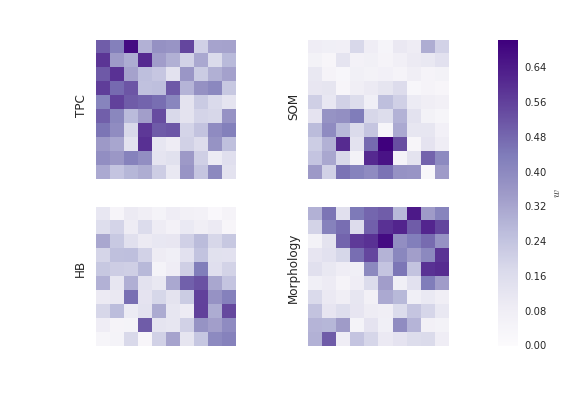

In [52]:
import base64
from IPython.display import HTML, Image, display

with open("bmc/images/som_colors.png", "rb") as image_file:
    im1 = 'data:image/png;base64,' + base64.b64encode(image_file.read())

with open("bmc/images/weights.png", "rb") as image_file:
    im2 = 'data:image/png;base64,' + base64.b64encode(image_file.read())

s = """<table>
<tr>
<th><img src="%s" height="500"></th>
<th><img src="%s" height="500"></th>
</tr></table>"""%(im1, im2)
display(HTML(s))

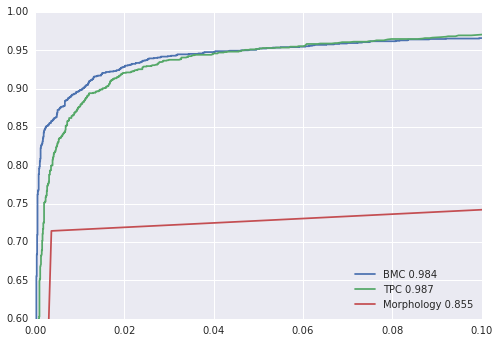

In [53]:
from sklearn.metrics import roc_curve, auc

for name, values in zip(['BMC', 'TPC', 'Morphology'], [clf_test, tpc_test, morph_test]):
    fpr, tpr, _ = roc_curve(truth_test, values)
    auc_score = '{:.3f}'.format(auc(fpr, tpr))
    plt.plot(fpr, tpr, label=name + ' {}'.format(auc_score))

plt.xlim(0, 0.1)
plt.ylim(0.6, 1)
plt.legend(loc='lower right')

In Figure 4, 
we compare the star and galaxy purity values
for BMC, TPC, and morphological separation
as functions of $i$-band magnitude.
We use the kernel density estimation ([Silverman 1986](https://ned.ipac.caltech.edu/level5/March02/Silverman/paper.pdf))
with the Gaussian kernel to smooth the fluctuations in the distribution.
Although morphological separation shows a slightly better performance
in galaxy purity at bright magnitudes $i \leq 20$,
BMC outperforms both TPC and morphological separation
at faint magnitudes $i \geq 21$.
As the top panel shows,
the number count distribution peaks at $i \sim 22$,
and BMC therefore outperforms both TPC and morphological separation
for the majority of objects.
It is also clear that BMC outperforms TPC over all magnitudes.
BMC can presumably accomplish this by combining information from
all base classifiers,
e.g., giving more weight to the morphological separation method
at bright magnitudes.
The bottom panel shows that
the star purity of morphological separation drops to $p_s < 0.8$
at fainter magnitudes $i > 21$.
This is expected, as our crude morphological separation classifies
every object as a galaxy beyond $i > 21$, and
purity measures the number of true stars classified as stars.
It is again clear that BMC outperforms both TPC and morphological separation
in star purity values over all magnitudes.

In [54]:
# define a class for showing PDF images
class PDF(object):
    def __init__(self, pdf, size=(200,200)):
        self.pdf = pdf
        self.size = size

    def _repr_html_(self):
        return '<iframe src={0} width={1[0]} height={1[1]}></iframe>'.format(self.pdf, self.size)

In [55]:
PDF('paper/figures/purity_mag.pdf', size=(600, 900))

[See code for Figure 4](paper/notebooks/figure04/purity_mag_kde.ipynb)

Figure 4. Purity as a function of the $i$-band magnitude
  as estimated by the kernel density estimation (KDE) method
  for the differential counts.
  The top panel shows the histogram with a bin size of 0.1 mag
  and the KDE for objects in the test set.
  The second panel shows the fraction of stars estimated by KDE
  as a function of magnitude.
  The bottom two panels compare
  the galaxy and star purity values for BMC, TPC, and
  morphological separation as functions of magnitude.
  Results for BMC, TPC, and morphological separation are in
  blue, green, and red, respectively.
  The $1 \sigma$ confidence bands are estaimted by
  bootstrap sampling.

In Figure 5, we show the
cumulative galaxy and star purity values as functions of magnitude.
Although morphological separation performs better than TPC
at bright magnitudes, its purity values decrease as 
the magnitudes become fainter, and
TPC eventually outperforms morphological separation by 1-2% at
$i > 21$.
BMC clearly outperforms both TPC and morphological separation,
and it maintains the overall galaxy purity of 0.980
up to $i \sim 24.5$.

In [56]:
PDF('paper/figures/purity_mag_integrated.pdf', size=(600, 650))

[See code for Figure 5](paper/notebooks/figure05/purity_mag_integrated.ipynb)

Figure 5. Purity as a function of the $i$-band magnitude
  for the integrated counts.
  The upper panel compares
  the galaxy purity values for BMC (blue solid line),
  TPC (green dashed line), and
  morphological separation (red dashed line).
  The lower panel compares the star purity.
  The $1 \sigma$ error bars are computed following the method
  of [Paterno (2003)](http://home.fnal.gov/~paterno/images/effic.pdf)
  to avoid the unphysical
  errors of binomial or Poisson statistics.

We also show the star and galaxy purity values as functions of
photometric redshift estimate in Figure 6.
Photo-$z$ is estimated with
the [BPZ algorithm](http://acs.pha.jhu.edu/~txitxo/bpz.html) ([Benitez 2000](http://adsabs.harvard.edu/abs/2000ApJ...536..571B))
and provided with
the [CFHTLenS](http://cfhtlens.org/) photometric redshift catalogue ([Hildebrandt et al. 2012](http://adsabs.harvard.edu/abs/2012MNRAS.427..146H)).
The advantage of BMC over TPC and morphological separation is
now more pronounced in Figure 5.
Although the morphological separation method outperforms BMC
at bright magnitudes in Figure 4,
it is clear that BMC outperforms
both TPC and morphological separation over all redshifts.

In [57]:
PDF('paper/figures/purity_z.pdf', size=(600, 900))

[See code for Figure 6](paper/notebooks/figure06/purity_z.ipynb)

Figure 6. Similar to [Figure 4](paper/notebooks/figure04/purity_mag_kde.ipynb)
but as a function of photo-$z$. The bin size of histogram in the top panel is 0.02.

We also present in Figure 7
how the star and galaxy purity values vary
as a function of $g-r$ color.
It is again clear that BMC outperforms
both TPC and morphological separation over all $g-r$ colors.

In [58]:
PDF('paper/figures/purity_g_r.pdf', size=(600, 900))

[See code for Figure 7](paper/notebooks/figure07/purity_g-r.ipynb)

Figure 7. Similar to [Figure 4](paper/notebooks/figure04/purity_mag_kde.ipynb)
but as a function of $g-r$. The bin size of histogram in the top panel is 0.05.

In Figure 8,
we show the distribution of $P(S)$,
the posterior probability that an object is a star,
for BMC, TPC, and morphological separation.
It is interesting that the BMC technique assigns
a posterior star probability $P(S) \leq 0.3$
to significantly more true galaxies than TPC,
and a probability $P(S) \geq 0.8$ to significantly fewer true galaxies.
By utilizing information from different types of classification techniques
in different parts of the parameter space,
BMC becomes more certain that an object is a star or a galaxy,
resulting in improvement of overall performance.

In [59]:
PDF('paper/figures/p_dist.pdf', size=(600, 600))

[See code for Figure 8](paper/notebooks/figure08/p_dist.ipynb)

Figure 8. Histogram of the posterior probability that a source is a star
for mophological separation (top), TPC (middle), and BMC (bottom)
for a high-quality training data set.
The true galaxies are in green, and the true stars are in blue.
The bin size is 0.05.

### V.3. Heterogeneous Training

 
It is very costly in terms of telescope time to
obtain a large sample of spectroscopic observations
down to the limiting magnitude of a photometric sample.
Thus, we investigate the impact of training set quality
by considering a more realistic case
where the training data set is available
only for a small number of objects with bright magnitudes.
To emulate this scenario,
we only use objects that have spectroscopic labels
from the VVDS 0226-04 field (which is located within the CFHTLS W1 field)
and impose a magnitude cut of $i < 22.0$ in the training data,
leaving us a training set with only 1,365 objects.
We apply the same four star-galaxy classification techniques
and four combination methods,
and measure the performance of each technique on the same test data set
from Section V.2.
As the top two panels of Figures 11, 13, and 14 show,
the demographics of objects in the training set
are different from the distribution of sources in the test set.
Thus, this also serves as a test of the efficacy of heterogeneous training.

We present in Table 3
the same six metrics for each method,
and highlight the best method for each metric.

In [60]:
HTML('''
<table style="width:100%">
  <tr>
    <td>Classifier</td>
    <td>AUC</td>
    <td>MSE</td>
    <td>$p_g (c_g=0.9964)$</td>
    <td>$p_s (c_s=0.7145)$</td>
    <td>$p_g (c_g=0.9600)$</td>
    <td>$p_s (c_s=0.2500)$</td>
  </tr>
  <tr>
    <td>TPC</td>
    <td>0.9399</td>
    <td>0.0511</td>
    <td>0.9350</td>
    <td>0.7060</td>
    <td>0.9570</td>
    <td>0.9747</td>
  </tr>
  <tr>
    <td>SOMc</td>
    <td>0.8861</td>
    <td>0.0989</td>
    <td>0.8843</td>
    <td>0.4316</td>
    <td>0.9165</td>
    <td>0.6263</td>
  </tr>
  <tr>
    <td>HB</td>
    <td>0.9386</td>
    <td>0.0760</td>
    <td>0.9325</td>
    <td>0.6911</td>
    <td>0.9424</td>
    <td>0.6918</td>
  </tr>
  <tr>
    <td>Morphology</td>
    <td>-</td>
    <td>0.0397</td>
    <td>0.9597</td>
    <td>0.9666</td>
    <td>-</td>
    <td>-</td>
  </tr>
  <tr>
    <td>WA</td>
    <td>0.9600</td>
    <td>0.0536</td>
    <td>0.9208</td>
    <td>0.8818</td>
    <td>0.9757</td>
    <td>0.9815</td>
  </tr>
  <tr>
    <td>BoM</td>
    <td>0.9587</td>
    <td>0.1511</td>
    <td>0.9658</td>
    <td>0.9862</td>
    <td>0.9790</td>
    <td>0.9977</td>
  </tr>
  <tr>
    <td>Stacking</td>
    <td>0.9442</td>
    <td>0.1847</td>
    <td>0.9561</td>
    <td>0.9309</td>
    <td>0.9664</td>
    <td>0.9983</td>
  </tr>
  <tr>
    <td>BMC</td>
    <td><b>0.9738</b></td>
    <td><b>0.0291</b></td>
    <td><b>0.9696</b></td>
    <td><b>0.9862</b></td>
    <td><b>0.9856</b></td>
    <td><b>1.0000</b></td>
  </tr>
</table>''')

Classifier,AUC,MSE,$p_g (c_g=0.9964)$,$p_s (c_s=0.7145)$,$p_g (c_g=0.9600)$,$p_s (c_s=0.2500)$
TPC,0.9399,0.0511,0.9350,0.7060,0.9570,0.9747
SOMc,0.8861,0.0989,0.8843,0.4316,0.9165,0.6263
HB,0.9386,0.0760,0.9325,0.6911,0.9424,0.6918
Morphology,-,0.0397,0.9597,0.9666,-,-
WA,0.9600,0.0536,0.9208,0.8818,0.9757,0.9815
BoM,0.9587,0.1511,0.9658,0.9862,0.9790,0.9977
Stacking,0.9442,0.1847,0.9561,0.9309,0.9664,0.9983
BMC,0.9738,0.0291,0.9696,0.9862,0.9856,1.0000


[See code for Table 3](paper/notebooks/table03/metrics_cut.ipynb)

Table 3. A summary of the classification performance metrics
  for the four individual methods
  and the four different classification combination methods
  when the training data set consists of
  only the sources that are in CFHTLS W1 field,
  has spectroscopic labels available from VVDS,
  and has $i < 22$.
  The definition of the metrics is summarized in
  Table 1.
  The bold entries highlight the best performance values
  within each column.}

Overall, the results obtained for the reduced data set are remarkable.
With a smaller training set, our training based methods, TPC and SOMc,
suffer a significant decrease in performance.
The performance of morphological separation and HB
is essentially unchanged from Table~\ref{table:metrics_all}
as they do not depend on the training data.
Without sufficient training data,
the advantage of combining the predictions of different classifiers
is more obvious.
Even WA, the simplest of combination techniques, outperforms
all individual classification techniques in four metrics,
AUC, $p_s$ at $c_s=0.7145$, $p_g$ at $c_g=0.9600$, and $p_s$ at $c_s=0.2500$.
Although BoM always chooses TPC as the best model
when we have a high-quality training set,
it now chooses various methods in different bins
and outperforms all base classifiers.
While the performance of the stacking technique is only slightly worse
than that of BMC when we have a high-quality training set,
stacking now fails to outperform morphological separation.
BMC shows an impressive performance and 
outperforms all other classification techniques in all six metrics.
Overall, the improvements are small but still significant
since these metrics are averaged over the full test data.

In Figure 9 and 10, we again show the $10\times10$
two-dimensional weight maps defined by the SOM.

In [61]:
im1 = 'paper/figures/som_colors_cut.pdf'
im2 = 'paper/figures/weights_cut.pdf'

width = 450
height = 350

caption1 = 'Figure 9. Similar to Figure 2 but for the reduced training data set.'
caption2 = 'Figure 10. Similar to Figure 3 but for the reduced training data set.'

HTML("""<table>
<tr>
  <th>
    <p>
      <iframe src="{0}" width="{2}" height="{3}"></iframe>
      <br><center>{4}</center></br>
    </p>
  </th>
  <th>
    <p>
      <iframe src="{1}" width="{2}" height="{3}"></iframe>
      <br><center>{5}</center></br>
    </p>
  </th>
</tr></table>""".format(im1, im2, width, height, caption1, caption2))

Figure 9. Similar to Figure 2 but for the reduced training data set.,Figure 10. Similar to Figure 3 but for the reduced training data set.


[See code for Figure 9](paper/notebooks/figure10/som_colors_cut.ipynb)

[See code for Figure 10](paper/notebooks/figure10/weights_cut.ipynb)

When the quality of training data is relatively poor,
the performance of training based algorithms will decrease,
while the performance of template fitting algorithms
or morphological separation methods
is independent of training data.
Thus, when the weight maps of Figure 3
and Figure 10 are visually compared,
it is clear that
the BMC algorithm now uses more information from
morphological separation and HB,
while it uses considerably less information from 
our training based algorithms, TPC and SOMc.
Not surprisingly, the morphological separation method
performs best at bright magnitudes,
and BMC assigns more weight to HB at fainter magnitudes.

In [62]:
im1 = 'paper/figures/weights.pdf'
im2 = 'paper/figures/weights_cut.pdf'

width = 450
height = 300

HTML("""<table>
<tr>
  <th>
    <p>
      <iframe src="{0}" width="{2}" height="{3}"></iframe>
      <br><center>High-quality training</center></br>
    </p>
  </th>
  <th>
    <p>
      <iframe src="{1}" width="{2}" height="{3}"></iframe>
      <br><center>Poor training</center></br>
    </p>
  </th>
</tr></table>""".format(im1, im2, width, height))

High-quality training,Poor training


We present the star and galaxy purity values as functions of
$i$-band magnitude in Figure 11.

In [63]:
PDF('paper/figures/purity_mag_cut.pdf', size=(600, 1000))

[See code for Figure 11](paper/notebooks/figure11/purity_mag_cut.ipynb)

Figure 11. Purity as a function of the $i$-band magnitude
  for the reduced training data set.
  Top panel shows the histograms and KDEs
  for the number count distribution for
  the training (blue) and test (green) data set.
  The second panel shows the fraction of stars
  in the training and test data set in blue and green, respectively.
  The bottom two panels compare
  the galaxy and star purity values for BMC, TPC,
  and morphological separation as functions of $i$-band magnitude.

The normalized density distribution as a function of magnitude
in the top panel
and the stellar distribution in the second panel
clearly show that the demographics of the training set and 
that of the test set are different.
Since the training set is cut at $i < 22$,
the density distribution falls off sharply around $i \sim 22$
and has a higher fraction of stars than the test set.
Compared to the purity values in Figure 4,
TPC now suffers a significant decrease in star and galaxy purity.
However, the purity of BMC does not show such a significant drop
and decreases by only 2-5%.
As suggested by the weight maps in Figure 10,
BMC can accomplish this by shifting the relative weights assigned to
each base classifier in different SOM cells.
As the quality of training set worsens,
BMC assigns less weight to training based methods
and more weight to HB and morphological separation.

In Figure 12, we show the
cumulative galaxy and star purity values as functions of magnitude.

In [64]:
PDF('paper/figures/purity_mag_cut_integrated.pdf', size=(600, 650))

[See code for Figure 12](paper/notebooks/figure12/purity_mag_cut_integrated.ipynb)

Figure 12. Similar to [Figure 5](paper/notebooks/figure05/purity_mag_integrated.ipynb)
but for the reduced training set.

Compared to Figure 5,
the drop in the performance of TPC is clear.
However, even when some classifiers have been trained on
a significantly reduced training set,
BMC maintains a galaxy purity of 0.970 and a star purity of 1.0
up to $i \sim 24.5$, and it sill outperforms morphological separation
at fainter magnitudes $i \geq 21$.

We also show the star and galaxy purity values as functions of
photo-$z$ in Figure 13
and as functions of $g-r$ in Figure 14.

In [65]:
PDF('paper/figures/purity_z_cut.pdf', size=(600, 1000))

[See code for Figure 13](paper/notebooks/figure13/purity_z_cut.ipynb)

Figure 13. Similar to [Figure 11](paper/notebooks/figure11/purity_mag_cut.ipynb)
but as a function of photo-$z$.

In [66]:
PDF('paper/figures/purity_g_r_cut.pdf', size=(600, 1000))

[See code for Figure 14](paper/notebooks/figure14/purity_g_r_cut.ipynb)

Figure 14. Similar to [Figure 11](paper/notebooks/figure11/purity_mag_cut.ipynb)
but as a function of $g-r$ color.

Compared to Figure 6 and 7,
the performance of BMC becomes worse in some photo-$z$ and $g-r$ bins.
However, this drop in performance seems to be confined to
only a small number of objects in particular regions of
the parameter space,
and BMC still outperforms both TPC and morphological separation
for the majority of objects.

Compared to Figure 8,
the difference between the posterior star probability distribution of
TPC and that of BMC is now more pronounced in Figure 15.

In [67]:
PDF('paper/figures/p_dist_cut.pdf', size=(600, 600))

[See code for Figure 15](paper/notebooks/figure15/p_dist_cut.ipynb)

Figure 15. Similar to [Figure 8](paper/notebooks/figure08/p_dist.ipynb)
but for the reduced training data set.

The $P\left(S\right)$ distribution of BMC for true galaxies
falls off sharply at $P\left(S\right)\approx0.95$,
and BMC does not assign a star probability
$P(S) \geq 0.95$ to any true galaxies,
On the other hand, both TPC and morphological separation 
classify some true galaxies as stars with absolute certainty.

### V.4. The Quality of Training Data

The combination techniques that we have demonstrated so far use
two training based algorithms as base classifiers.
Ideally, the training data should mirror the entire parameter space
occupied by the data to be classified.
Yet we have seen in Section V.3
that the BMC technique does reliably
extrapolate past the limits of the training data,
even when some base classifiers are trained on a low-quality training data set.
In this section, we further investigate
if and where BMC begins to break down
by imposing various magnitude, photo-$z$, and color cuts
to change the size and composition of the training set.

In Figure 16, we present
a visual comparison between different classification techniques,
when various magnitude cuts are applied on the training data,
and the performance is measured on the same test set
from Section V.2 and V.3.

In [68]:
PDF('paper/figures/perform_mag_cut.pdf', size=(600, 1000))

[See code for Figure 16](paper/notebooks/figure16/perform_mag_cut.ipynb)

Figure 16. The classification performance metrics for
  BMC (blue), TPC (green), morphology (red), and HB (purple)
  as applied to the CFHTLenS data in the VVDS field
  with various magnitude cuts.
  The top panel shows the number of sources in the training set
  at corresponding magnitude cuts.
  We show only one of the four combination methods, BMC,
  which has the best overall performance.

It is not surprising that the performance of TPC decreases
as we decrease the size of training set
by imposing more restrictive magnitude cuts,
while the performance of HB and morphological separation
is essentially unchanged.
However, the effect of change in size and composition of the training set
is significantly mitigated by the use of the BMC technique.
BMC outperforms both HB and TPC in all four metrics,
even when the training set is restricted to $i < 20.0$.
BMC also consistently outperforms morphological separation
until we impose a magnitude cut of $i < 20.0$ on the training data,
beyond which point BMC finally performs worse than morphological separation.
It is remarkable that BMC is able to reliably extrapolate
past the training data to $i \sim 24.5$,
the limiting magnitude of the test set, and outperform HB, TPC,
and morphological separation in all performance metrics,
even the demographics of training set do not accurately sample 
the data to be classified.

Similarly, we impose various spectroscopic redshift cuts 
on the training data in Figure 17.

In [69]:
PDF('paper/figures/perform_z_cut.pdf', size=(600, 1000))

[See code for Figure 17](paper/notebooks/figure17/perform_z_cut.ipynb)

Figure 17. Similar to [Figure 16](paper/notebooks/figure16/perform_mag_cut.ipynb) but using $z_{\text{spec}}$ cuts.

Since all stars have $z_{\mathrm{spec}}$ values
close to zero, we are effectively changing the demographics
of training set by keeping all stars and gradually removing
galaxies with high redshifts.
BMC begins to perform worse than morphological separation
when a conservative cut of $z_{\mathrm{spec}} < 0.6$ is imposed.
However, it is again clear that BMC is able to
utilize information from HB and morphological separation to
mitigate the drop in the performance of TPC.

In Figure 18,
we decrease the size of training set
by keeping red objects and gradually removing blue objects.

In [70]:
PDF('paper/figures/perform_g_r_cut.pdf', size=(600, 1000))

[See code for Figure 18](paper/notebooks/figure18/perform_g_r.ipynb)

Figure 18. Similar to [Figure 16](paper/notebooks/figure16/perform_mag_cut.ipynb) but using $g-r$ color cuts.

A color cut seems to have a more pronounced effect
on the performance of TPC and BMC,
which perform worse than morphological separation
when the training set is restricted to $g - r > 0.4$.
The performance depends more strongly on the color distribution, because 
a significant fraction of blue objects consists of stars,
while objects with fainter magnitudes and higher redshifts
are mostly galaxies.
We can verify this in Figure 2,
where the darker (higher stellar fraction) cells in the upper middle region
of the stellar fraction map (top right panel)
have bright magnitudes $i \leq 20$
in the $i$-band magnitude map (top left panel)
and blue colors $g-r \leq 0.5$ in the $g-r$ color map (bottom right panel).
On the other hand, the darker (fainter magnitude) cells
in the right-hand side of the $i$-band magnitude map
have almost no stars in them and
are represented by bright (low stellar fraction)
cells in the stellar fraction map.
Thus, these results indicate that the performance of training based
methods depends more strongly on the composition of training data
than on the size, and it is necessary to have
a sufficient number of the minority class
in the training data set to ensure optimal performance.

## VI. Conclusions

We have presented and analyzed a novel star-galaxy classification framework for combining star-galaxy classifiers using the CFHTLenS data. In particular, we use four independent classification techniques: a morphological separation method; TPC, a supervised machine learning technique based on prediction trees and a random forest; SOMc, an unsupervised machine learning approach based on self-organizing maps and a random atlas; and HB, a Hierarchical Bayesian template-fitting method that we have modified and parallelized. Both TPC and SOMc algorithms are currently available within a software package named [MLZ](http://lcdm.astro.illinois.edu/code/mlz.html). Our implementation of HB and BMC, as well as IPython notebooks that have been used to produce the results in this paper, are available at https://github.com/EdwardJKim/astroclass.  

Given the variety of star-galaxy classification methods we are using, we fully expect the relative performance of the individual techniques to vary across the parameter space spanned by the data. We therefore adopt the binning strategy, where we allow different classifier combinations in different parts of parameter space by creating two-dimensional self-organizing maps of the full multi-dimensional magnitude-color space. We apply different star-galaxy classification techniques within each cell of this map, and find that the four techniques are weighted most strongly in different regions of the map.   

Using data from the CFHTLenS survey, we have considered different scenarios: when an excellent training set is available with spectroscopic labels from DEEP2, SDSS, VIPERS, and VVDS, and when the demographics of sources in a low-quality training set do not match the demographics of objects in the test data set. We demonstrate that the Bayesian Model Combination (BMC) technique improves the overall performance over any individual classification method in both cases. We note that [Carrasco Kind (2014)](http://adsabs.harvard.edu/abs/2014MNRAS.442.3380C) analyzed different techniques for combining photometric redshift probability density functions (photo-$z$ PDFs) and also found that BMC is in general the best photo-$z$ PDF combination technique.   

The problem of star-galaxy classification is a rich area for future research. It is unclear if sufficient training data will be available in future ground-based surveys. Furthermore, in large sky surveys such as DES and LSST, photometric quality is not uniform across the sky, and a purely morphological classifier alone will not be sufficient, especially at faint magnitudes. Given the efficacy of our approach, classifier combination strategies are likely the optimal approach for currently ongoing and forthcoming photometric surveys. We therefore plan to apply the combination technique described in this paper to other surveys such as the DES. Our approach can also be extended more broadly to classify objects that are neither stars nor galaxies (e.g., quasars). Finally, future studies could explore the use of multi-epoch data, which would be particularly useful for the next generation of synoptic surveys.

## Acknowledgements

The authors thank the referee for a careful reading of the manuscript and comments that improved this work. We thank Ignacio Sevilla for helpful and insightful conversations. We acknowledge support from the  National Science Foundation Grant No. AST-1313415. RJB acknowledges support as an Associate within the Center for Advanced Study at the University of Illinois.

This work used the Extreme Science and Engineering Discovery Environment (XSEDE), which is supported by National Science Foundation grant number ACI-1053575.

This work is based on observations obtained with MegaPrime/MegaCam, a joint project of CFHT and CEA/DAPNIA, at the Canada-France-Hawaii Telescope (CFHT) which is operated by the National Research Council (NRC) of Canada, the Institut National des Sciences de l'Univers of the Centre National de la Recherche Scientifique (CNRS) of France, and the University of Hawaii. This research used the facilities of the Canadian Astronomy Data Centre operated by the National Research Council of Canada with the support of the Canadian Space Agency. CFHTLenS data processing was made possible thanks to significant computing support from the NSERC Research Tools and Instruments grant program.

Funding for the DEEP2 survey has been provided by NSF grants AST-0071048, AST-0071198, AST-0507428, and AST-0507483. 

Funding for SDSS-III has been provided by the Alfred P. Sloan Foundation, the Participating Institutions, the National Science Foundation, and the U.S. Department of Energy Office of Science. The SDSS-III web site is http://www.sdss3.org/.

SDSS-III is managed by the Astrophysical Research Consortium for the Participating Institutions of the SDSS-III Collaboration including the University of Arizona, the Brazilian Participation Group, Brookhaven National Laboratory, Carnegie Mellon University, University of Florida, the French Participation Group, the German Participation Group, Harvard University, the Instituto de Astrofisica de Canarias, the Michigan State/Notre Dame/JINA Participation Group, Johns Hopkins University, Lawrence Berkeley National Laboratory, Max Planck Institute for Astrophysics, Max Planck Institute for Extraterrestrial Physics, New Mexico State University, New York University, Ohio State University, Pennsylvania State University, University of Portsmouth, Princeton University, the Spanish Participation Group, University of Tokyo, University of Utah, Vanderbilt University, University of Virginia, University of Washington, and Yale University.

This paper uses data from the VIMOS Public Extragalactic Redshift Survey (VIPERS). VIPERS has been performed using the ESO Very Large Telescope, under the "Large Programme" 182.A-0886. The participating institutions and funding agencies are listed at http://vipers.inaf.it/.

This research uses data from the VIMOS VLT Deep Survey, obtained from the VVDS database operated by Cesam, Laboratoire d'Astrophysique de Marseille, France.